#Load packages

In [1]:
#!pip install sparqlwrapper
#!pip install powerlaw

SyntaxError: invalid syntax (885852317.py, line 1)

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import networkx as nx
import networkx.algorithms.community as nx_comm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

import numpy as np
import pandas as pd
from collections import Counter

import powerlaw
import math
import random


#Part1: Collecting data

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"

In [3]:
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

##Part1.1 :  Collecting only jazz performances data

In [4]:
query = """SELECT DISTINCT ?concert_mjf ?concert_name (group_concat(DISTINCT ?participant_name;separator=";") as ?participant_names)  ?wd_time ?location_name  (group_concat(DISTINCT ?genre_name;separator=";") as ?genre_names)
WHERE { 
    { ?concert_mjf wdt:P8300 ?wd_item } .
    OPTIONAL { ?concert_mjf wdt:P361 ?wd_part_of } .
    OPTIONAL { ?concert_mjf wdt:P276 ?wd_location } .
    OPTIONAL { ?concert_mjf wdt:P585 ?wd_time } .
    OPTIONAL { ?concert_mjf wdt:P710 ?wd_participant} . 
    {?concert_mjf wdt:P136 ?wd_genre} .
    SERVICE wikibase:label { 
        bd:serviceParam wikibase:language "en" .
        ?concert_mjf rdfs:label ?concert_name .
        ?wd_location rdfs:label ?location_name .
        ?wd_participant rdfs:label ?participant_name .
        ?wd_genre rdfs:label ?genre_name
    }
   FILTER regex(str(?genre_name),"jazz|bebop|bop|swing")
   
}
GROUP BY ?concert_mjf ?concert_name  ?location_name ?wd_time 
ORDER BY ASC (?wd_time)"""

results_jazz= get_results(endpoint_url, query)


##Part1.2 :  Collecting all performances data

In [5]:

query = """SELECT DISTINCT ?concert_mjf ?concert_name (group_concat(?participant_name;separator=";") as ?participant_names)  ?wd_time ?location_name ?genre_name
WHERE { 
    { ?concert_mjf wdt:P8300 ?wd_item } .
    OPTIONAL { ?concert_mjf wdt:P361 ?wd_part_of } .
    OPTIONAL { ?concert_mjf wdt:P276 ?wd_location } .
    OPTIONAL { ?concert_mjf wdt:P585 ?wd_time } .
    OPTIONAL { ?concert_mjf wdt:P710 ?wd_participant} . 
    {?concert_mjf wdt:P136 ?wd_genre} .
    SERVICE wikibase:label { 
        bd:serviceParam wikibase:language "en" .
        ?concert_mjf rdfs:label ?concert_name .
        ?wd_location rdfs:label ?location_name .
        ?wd_participant rdfs:label ?participant_name .
        ?wd_genre rdfs:label ?genre_name
    }
 
   
}
GROUP BY ?concert_mjf ?concert_name  ?location_name ?wd_time ?genre_name
ORDER BY ASC (?wd_time)"""


results_all = get_results(endpoint_url, query)

KeyboardInterrupt: 

##Part1.3 :  Collecting all artists data

In [5]:
class Musician(object):
  def __init__(self, name, gender,countries,instruments ):
    self.name = name
    self.gender = gender
    self.countries= countries
    self.instruments=instruments

  def to_dict(self):
        return {
            'name': self.name,
            'gender': self.gender,
            'countries' :self.countries,
            'instruments' : self.instruments
        }   

In [6]:
query = """SELECT DISTINCT ?wd_item ?wd_item_label ?wd_gender_label (group_concat(DISTINCT ?wd_instrument_label;separator=";") as ?wd_instrument_labels)  (group_concat(DISTINCT ?wd_country_label;separator=";") as ?wd_country_labels)
WHERE { 
    ?wd_item wdt:P8301 ?mjf_person_id .
    OPTIONAL {?wd_item wdt:P21 ?mjf_gender} . 
    OPTIONAL {?wd_item wdt:P1303  ?mjf_instrument } .
    OPTIONAL { ?wd_item wdt:P27  ?mjf_country }     
    SERVICE wikibase:label { 
        bd:serviceParam wikibase:language "en" .
        ?wd_item rdfs:label ?wd_item_label . 
        ?mjf_gender rdfs:label ?wd_gender_label . 
        ?mjf_instrument rdfs:label ?wd_instrument_label .
        ?mjf_country  rdfs:label ?wd_country_label
    } 

 bind(  COALESCE( ?wd_country_label,"NaN") as ?wd_country_label)
 bind(  COALESCE( ?wd_instrument_label,"NaN") as ?wd_instrument_label)
 bind(  COALESCE( ?wd_gender_label,"NaN") as ?wd_gender_label)
} 

GROUP BY ?wd_item ?wd_item_label ?wd_gender_label """


results_artists = get_results(endpoint_url, query)

In [8]:
def get_artist(name): 

  query ="""SELECT ?item ?wd_item_label ?wd_gender_label  (group_concat(DISTINCT ?wd_instrument_label;separator=";") as ?wd_instrument_labels)  (group_concat(DISTINCT ?wd_country_label;separator=";") as ?wd_country_labels) WHERE {
          ?item wdt:P31 wd:Q5.
          ?item ?label """ + "\"" + str(name) + "\"" + """@en .
          {?item wdt:P106/wdt:P279 wd:Q639669 }
          UNION
          { ?item wdt:P106 wd:Q639669 }.
          OPTIONAL {?item wdt:P21      ?mjf_gender} . 
          OPTIONAL {?item wdt:P1303    ?mjf_instrument } .
          OPTIONAL {?item wdt:P27      ?mjf_country }  . 
 
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en". 
                                  ?item rdfs:label ?wd_item_label . 
                                  ?mjf_gender rdfs:label ?wd_gender_label . 
                                  ?mjf_instrument rdfs:label ?wd_instrument_label .
                                  ?mjf_country  rdfs:label ?wd_country_label                 
                                
          }
          
          bind(  COALESCE( ?wd_country_label,"NaN") as ?wd_country_label)
          bind(  COALESCE( ?wd_instrument_label,"NaN") as ?wd_instrument_label)
          bind(  COALESCE( ?wd_gender_label,"NaN") as ?wd_gender_label)
       
        }
        GROUP BY ?item ?wd_item_label ?wd_gender_label """
  try :
     results_artist = get_results(endpoint_url, query)
     results_artist  = results_artist["results"]["bindings"]
  except Exception as e:
      return None

  if len(results_artist)==0:
    return None
    
  for r in results_artist :
    return Musician(r["wd_item_label"]["value"],r["wd_gender_label"]["value"],r["wd_country_labels"]["value"].split(sep=";"),r["wd_instrument_labels"]["value"].split(sep=";"))  

In [9]:
musicians =list()
for result in results_artists["results"]["bindings"]:
   musician= Musician(result["wd_item_label"]["value"],result["wd_gender_label"]["value"],result["wd_country_labels"]["value"].split(sep=";"),result["wd_instrument_labels"]["value"].split(sep=";"))
   musicians.append(musician)
   

In [ ]:
len(musicians)


16924

In [10]:
unknown =set()
jazz_musicians=list()
def get_musician(name):
  
  for m in musicians:
    if m.name == name :
      if not m in jazz_musicians:
        jazz_musicians.append(m)
      return m
 
  musician = get_artist(name)
 
  if musician==None :
     unknown.add(str(name))  
     return None

  jazz_musicians.append(musician)
  musicians.append(musician)   
  return musician

In [134]:
nb_female_voice =0
for jm in jazz_musicians :
    if jm.gender =="female" and "voice" in jm.instruments:
        nb_female_voice+=1

In [135]:
nb_female_voice

224

#Part2: Network construction

In [11]:
def build_network(results) :  
    G = nx.Graph()
    for result in results["results"]["bindings"]:
      participants = result["participant_names"]["value"]
      participants = participants.split(sep=";")
    
      for i in range(0,len(participants)-1):
          musician_in  = get_musician(participants[i])
          if musician_in== None :
              continue
          musician_in = musician_in.name
          for j in range(i+1,len(participants)):
              musician_out =get_musician(participants[j])
              if musician_out== None :
                continue
              musician_out =musician_out.name
              if not G.has_node(musician_in) :
                  G.add_node(musician_in)
                

              if not G.has_node(musician_out):
                  G.add_node(musician_out)   

              if not G.has_edge(musician_in,musician_out) :
                  G.add_edge(musician_in,musician_out,weight = 1)    
              else :
                  G[musician_in][musician_out]['weight'] = G[musician_in][musician_out]['weight'] + 1  
    return G         

In [12]:
net_jazz= build_network(results_jazz)
nx.write_gexf(net_jazz, "./jazz_network_with_label.gexf")

In [35]:
print(len(unknown))
print(unknown)

5
{'Shelby Vert', 'Tio Bilia', 'Soil & "Pimp" Sessions', 'John Bright', 'John McKenna'}


###Build dataframe from Sparql(up to date dataset)

In [13]:
df = pd.DataFrame.from_records([m.to_dict() for m in jazz_musicians])

In [ ]:
df

In [ ]:
df.to_csv("montreux_jazz_final.csv", sep=';', encoding='utf-8')

###Read data from csv(see git)

#Data analyze

In [15]:
df = df.replace("nan", np.NaN,regex=True)
df = df.replace('NaN', np.NaN,regex=True)

In [ ]:
df.isna().sum()

name             17
gender         1325
countries         0
instruments       0
dtype: int64

###Gender pie chart 

In [ ]:
df.loc[:,"gender"].value_counts(dropna=False)

male           3364
NaN            1325
female          323
trans woman       1
Name: gender, dtype: int64

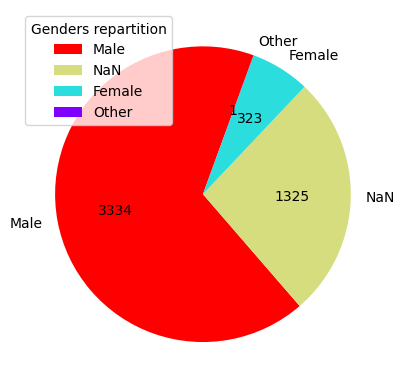

In [ ]:
y = df.loc[:,"gender"].value_counts(dropna=False)
mylabels = ["Male", "NaN", "Female","Other"]
colors = cm.rainbow_r(np.linspace(0, 1, len(mylabels)))
plt.pie(y, labels = mylabels,startangle = 70, autopct=lambda x: '{:.0f}'.format(x*y.sum()/100),colors=colors)
plt.legend(title = "Genders repartition")
plt.savefig("gender.eps", format="eps")
plt.show() 


###Country pie chart

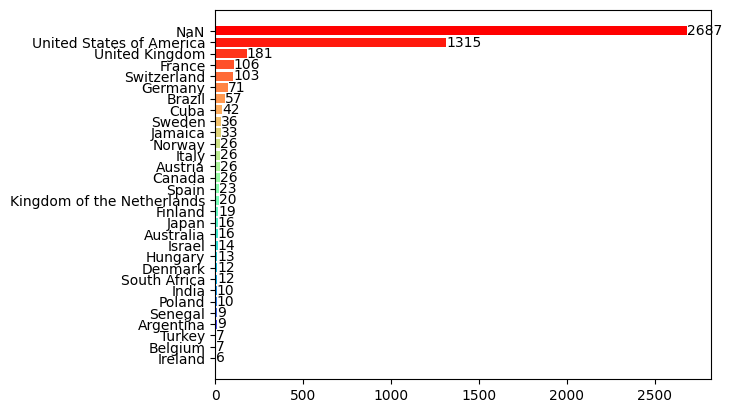

In [ ]:
countries_dict = dict(sorted(Counter(df.loc[:,"countries"].sum()).items(), key=lambda item: item[1]))
fig, ax = plt.subplots()
countries=list(countries_dict.keys())
countries_val=list(countries_dict.values())
colors = cm.rainbow(np.linspace(0, 1, 30))
bars = ax.barh(countries[-30:],countries_val[-30:],color=[c for c in colors])
labels_text = ax.bar_label(bars)
plt.savefig("countries.eps", format="eps",bbox_inches='tight')
plt.show()

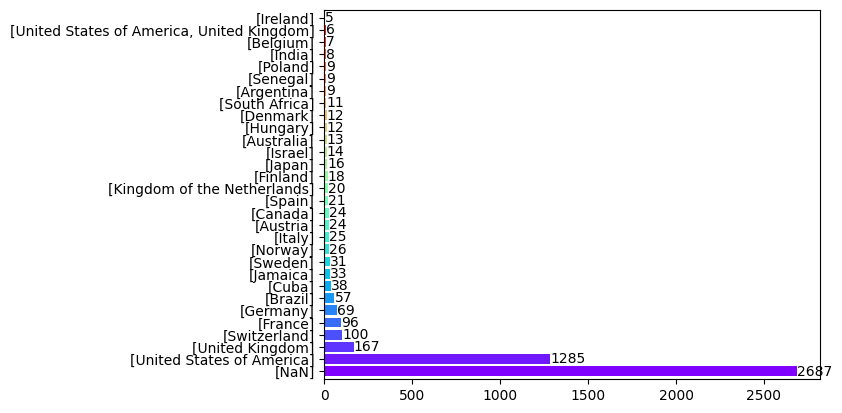

In [ ]:
y =df.loc[:,"countries"].value_counts(dropna=False)[0:30]
colors = cm.rainbow(np.linspace(0, 1, len(y)))
ax = y.plot.barh(width=0.8,color=[c for c in colors])

for container in ax.containers:
    ax.bar_label(container)
plt.savefig("country.eps", format="eps",bbox_inches='tight')
plt.show()


###Instruments charts

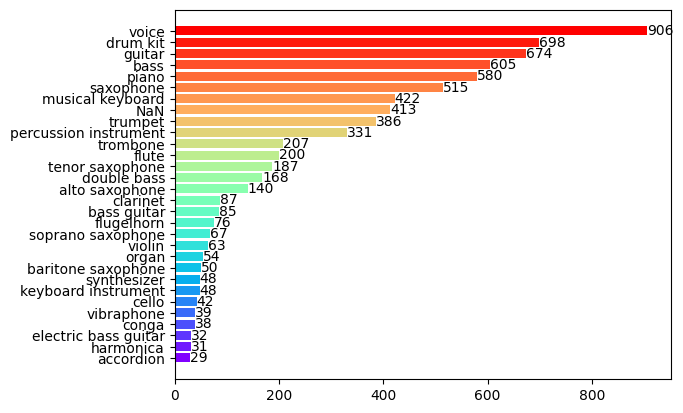

In [ ]:
instruments_dict = dict(sorted(Counter(df.loc[:,"instruments"].sum()).items(), key=lambda item: item[1]))
fig, ax = plt.subplots()
instruments=list(instruments_dict.keys())
instruments_val=list(instruments_dict.values())
colors = cm.rainbow(np.linspace(0, 1, 30))
bars = ax.barh(instruments[-30:],instruments_val[-30:],color=[c for c in colors])
labels_text = ax.bar_label(bars)
plt.savefig("instruments.eps", format="eps",bbox_inches='tight')
plt.show()


In [ ]:
net_all= build_network(results_all)
nx.write_gexf(net_all, "./all_network.gexf")

#Network visualisation

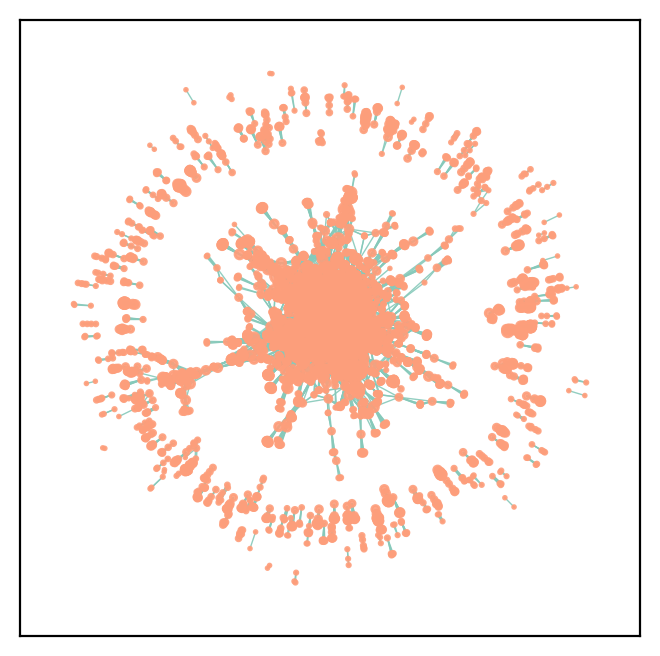

In [ ]:
pos = nx.spring_layout(net_jazz, 2/math.sqrt(net_jazz.order()))
d = dict(net_jazz.degree())
fig, _= plt.subplots(figsize=(4, 4),  dpi=200)
#color_lookup = {k:v for v, k in enumerate(sorted(set(net_jazz.nodes().name)))}
#low, *_, high = sorted(color_lookup.values())
#norm = colors.Normalize(vmin=low, vmax=high, clip=True)
#mapper = cm.ScalarMappable(norm=norm, cmap=cm.tab20c) #magma
node_color = ["#FD9E7B" if n == artist_max_degree else"#FD9E7B" for n in net_jazz.nodes()]
weights = [net_jazz[u][v]['weight']/2 for u,v in net_jazz.edges()]
nx.draw_networkx(net_jazz, pos=pos, node_size=[(v+1)/2 for v in d.values()], node_color =node_color, edge_color="#86C9BA", 
                 width=weights, with_labels=False, font_size = 0.4, font_color = "#393939", alpha=0.9)
plt.savefig("Graph2.JPEG", format="JPEG")

In [ ]:
def visualize_network(g,layout):
    
    pos = nx.spring_layout(g, 2/math.sqrt(g.order()))
    if layout == 1:
      pos = nx.kamada_kawai_layout(g)
    elif layout==2 :
      pos = nx.circular_layout(sorted(g.nodes()))
    d = dict(g.degree())
    fig, _= plt.subplots(figsize=(4, 4),  dpi=200)
    color_lookup = {k:v for v, k in enumerate(sorted(set(g.nodes())))}
    low, *_, high = sorted(color_lookup.values())
    norm = colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.tab20c) #magma
    #node_color = ["#FD9E7B" if n == artist_max_degree else"#FD9E7B" for n in g.nodes()]
    weights = [g[u][v]['weight']/2 for u,v in g.edges()]
    nx.draw_networkx(g, pos=pos, node_size=[(v+1)/2 for v in d.values()], node_color ="#FD9E7B", edge_color="#86C9BA", 
                    width=weights, with_labels=False, font_size = 0.4, font_color = "#393939", alpha=0.9)
    plt.savefig("Graph2.JPEG", format="JPEG")

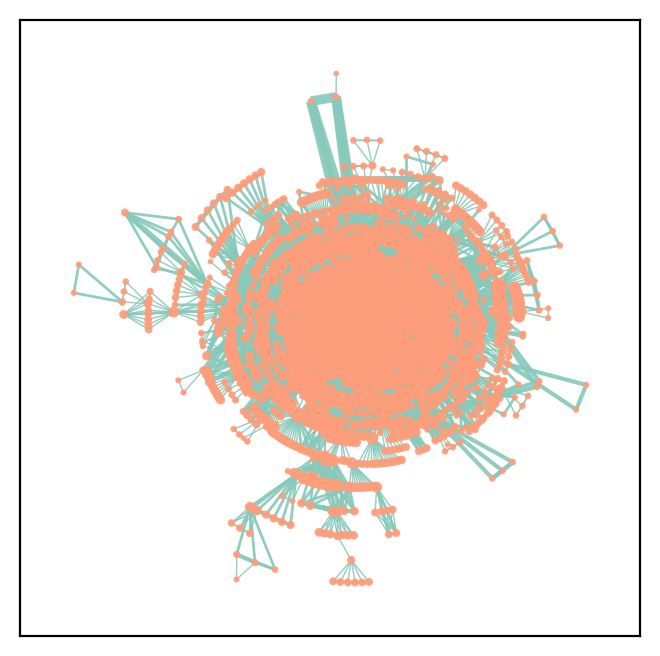

In [ ]:
visualize_network(net_jazz,1)

#Informations about the Networks

In [14]:
def get_network_info(g):
  print("nb nodes: ",len(g.nodes))
  print("nb edges: ",len(g.edges))
  deg = dict(nx.degree(g))
  deg = list(deg.values())
  print("Min node degree: ",np.min(deg))
  print("Max node degree: ",np.max(deg))
  print("Avg node degree: ",np.mean(deg))

###1.Jazz network

In [15]:
get_network_info(net_jazz)

nb nodes:  4955
nb edges:  29355
Min node degree:  1
Max node degree:  247
Avg node degree:  11.848637739656912


In [ ]:
degree_centralities =nx.degree_centrality(net_jazz).values()
print(max(degree_centralities))
print(min(degree_centralities))

0.049578482537133685
0.0002007226013649137


### Degree correlation

In [ ]:
r = nx.degree_pearson_correlation_coefficient(net_jazz)
print(f"{r:3.1f}")

0.3


###Local clustering coefficient

In [ ]:
from collections import Counter

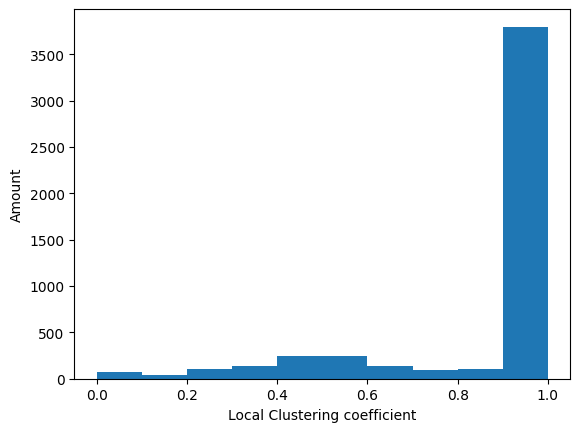

In [ ]:
clustering_coefficients= nx.clustering(net_jazz).values()
clustering_coefficients_occ=Counter(clustering_coefficients)

fig, ax = plt.subplots()
plt.hist(clustering_coefficients,bins=10)

plt.ylabel("Amount")
plt.xlabel("Local Clustering coefficient")
plt.savefig("local-clust-coeff_hist_log.eps", format="eps")
plt.show()

###Average clustering coefficient

In [ ]:
print("Average clustering coefficient : ", nx.average_clustering(net_jazz))

Average clustering coefficient :  0.8771957136797607


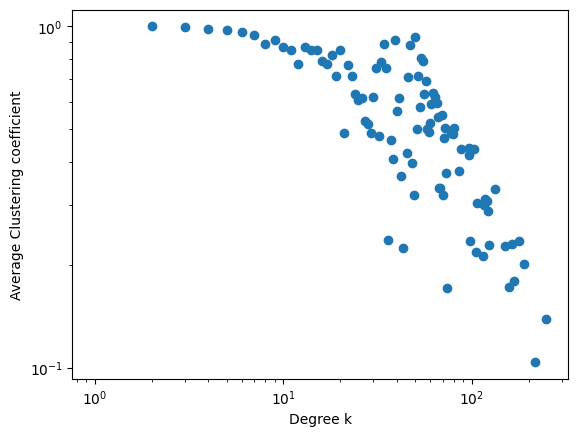

In [ ]:
from collections import defaultdict

d = defaultdict(list)

for u in net_jazz.nodes():
   d[net_jazz.degree(u)].append(u)

clustering_coeffs=defaultdict(np.double)
for degree in d:
   clustering_coeff = list(nx.clustering(net_jazz, d[degree]).values())
   clustering_coeffs[degree] = np.mean(clustering_coeff)

fig, ax = plt.subplots()

plt.plot(clustering_coeffs.keys(), clustering_coeffs.values(), 'o')
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylabel("Average Clustering coefficient")
plt.xlabel("Degree k")
plt.savefig("local-clust-coeff_hist_degre_log.eps", format="eps")
plt.show()


###Transitivity


In [ ]:
print("Transitivity : ", nx.transitivity(net_jazz))

Transitivity :  0.5517554742043437


###Average neighbor degree

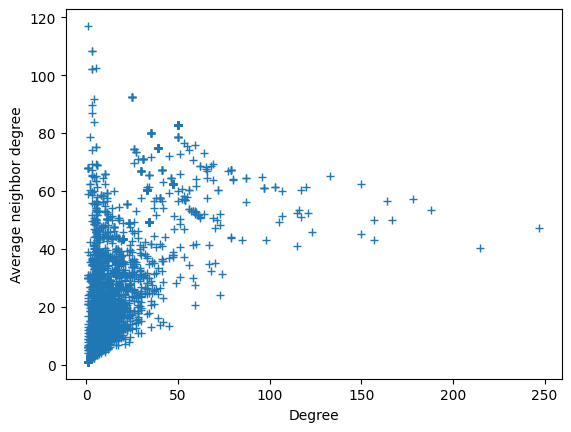

In [ ]:
avg_neighbor_deg=nx.average_neighbor_degree(net_jazz).values()
deg = dict(nx.degree(net_jazz))
deg = list(deg.values())
fig, ax = plt.subplots()
plt.plot(deg, avg_neighbor_deg, '+')
plt.ylabel("Average neighbor degree")
plt.xlabel("Degree")
plt.show()

#Analyze one artists neighborhood

In [21]:
top50musicians = sorted(net_jazz.degree, key=lambda x: x[1], reverse=True)[0:50]

In [15]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
degreeCount = Counter(degree_sequence)

NameError: name 'g' is not defined

In [ ]:
top50musicians

In [22]:
instruments=list()
genders=list()
countries=list()
degree_sequence =list()
idx = 0
for m in top50musicians :
  genders.append(m[0].gender)
  instruments.extend(m[0].instruments)
  countries.extend(m[0].countries)
  degree_sequence.append(m[1]) 
  if m[0].gender=='NaN' :
    top50musicians[idx][0].gender="male"
  if m[0].gender=='female' :
    print(m[0].name ,"",m[1]," ", m[0].instruments, "  ",m[0].countries) 
  idx+=1

Patti Austin  188   ['voice']    ['New York City']
Chaka Khan  164   ['voice']    ['Chicago']
Angélique Kidjo  123   ['voice']    ['Ouidah']
Rachelle Ferrell  105   ['piano', 'musical keyboard', 'upright piano', 'voice']    ['Philadelphia']
Patrice Rushen  96   ['piano', 'musical keyboard', 'voice']    ['Los Angeles']
Petula Clark  79   ['piano', 'voice']    ['Ewell']
Randy Crawford  70   ['voice']    ['Macon']


In [126]:
print(genders)
print(instruments)
print(countries)
print(degree_sequence)

['male', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female']
['piano', 'trumpet', 'keyboard instrument', 'drum kit', 'horn', 'synthesizer', 'voice', 'piano', 'synthesizer', 'musical keyboard', 'electronic keyboard', 'voice', 'voice', 'guitar', 'bass guitar', 'double bass', 'bass', 'voice', 'NaN', 'voice', 'drum kit', 'percussion instrument', 'marimba', 'voice', 'piano', 'saxophone', 'alto saxophone', 'guitar', 'violin', 'harmonica', 'chromatic harmonica', 'piano', 'flute', 'synthesizer', 'musical keyboard', 'keytar', 'electric piano', 'electronic keyboard', 'ARP Chroma', 'piano', 'musical keyboard', 'electronic keyboard', 'voice', 'voice'

###degree distribution of the top 50 nodes

In [17]:
from collections import defaultdict

In [100]:
dic = defaultdict(list)
for m in top50musicians : 
    dic[m[1]] .append(m[0].name)

In [ ]:
dic

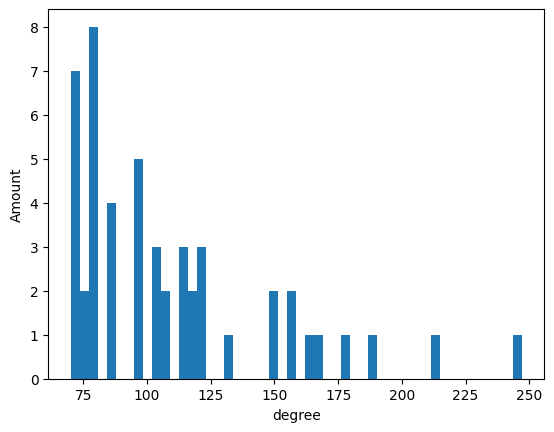

In [128]:

fig, ax = plt.subplots()
plt.hist(degree_sequence,bins=50)

plt.ylabel("Amount")
plt.xlabel("degree")
plt.savefig("local-clust-coeff_hist_log.eps", format="eps")
plt.show()

###Gender repartition for top 25 nodes

In [ ]:
dict(Counter(genders).items()).values()

dict_values([21, 4])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


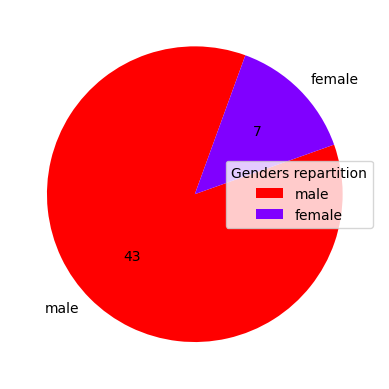

In [127]:
y = dict(Counter(genders).items())
mylabels = list(y.keys())
y=list(y.values())
colors = cm.rainbow_r(np.linspace(0, 1, len(mylabels)))
plt.pie(y, labels = mylabels,startangle = 70, autopct=lambda x: '{:.0f}'.format(x*sum(y)/100),colors=colors)
plt.legend(title = "Genders repartition")
plt.savefig("hub_gender.eps", format="eps")
plt.show() 


###Instruments repartition for top 25 nodes

In [19]:
from matplotlib.pyplot import figure

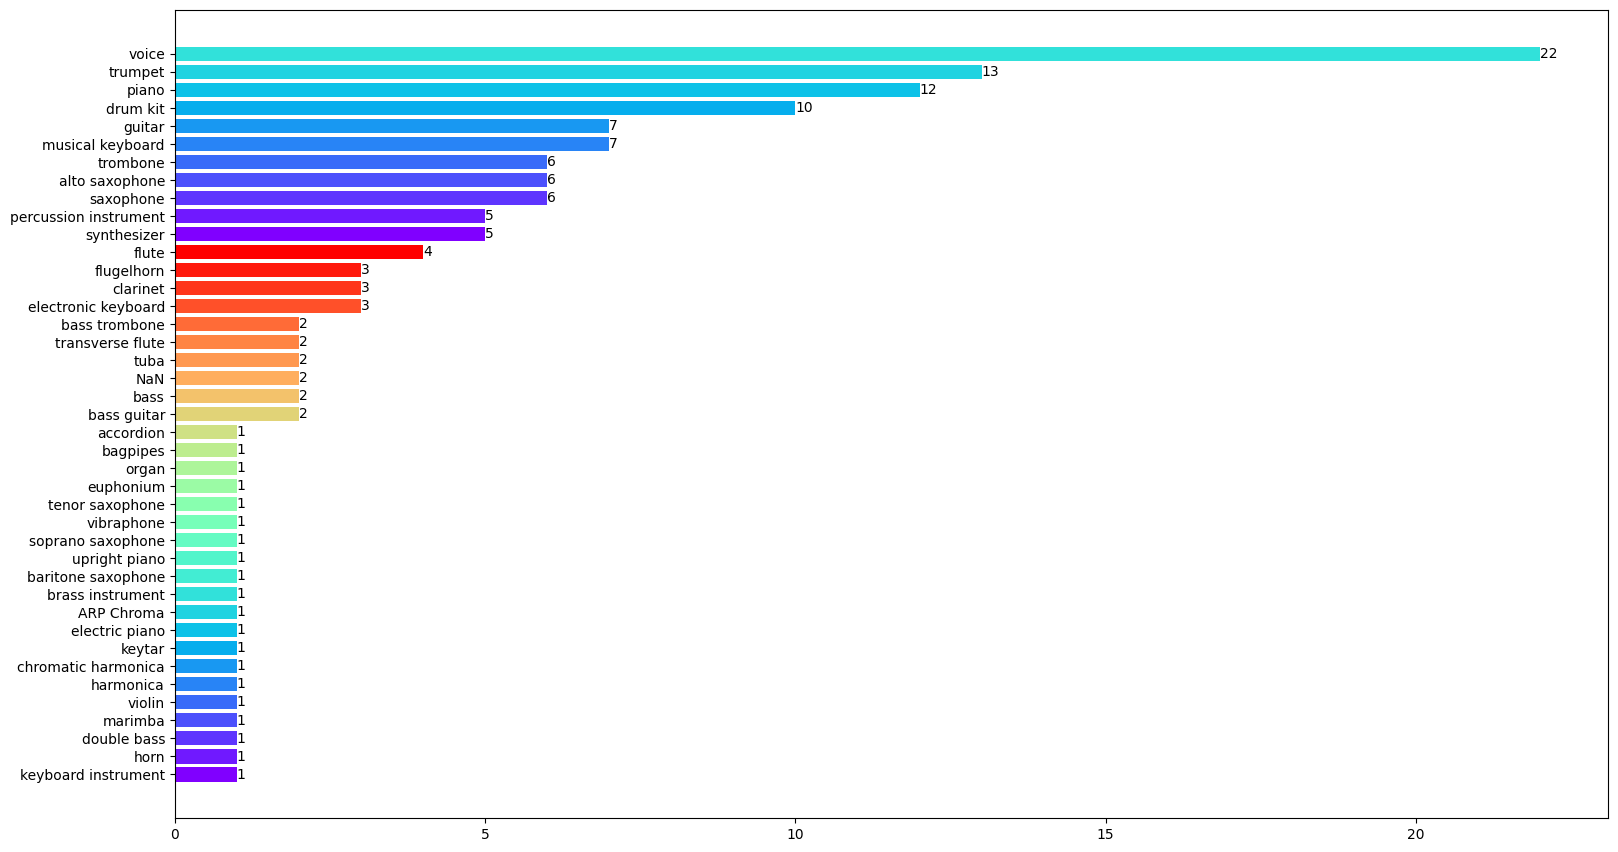

In [129]:
instruments_dict = dict(sorted(Counter(instruments).items(), key=lambda item: item[1]))
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
instruments=list(instruments_dict.keys())
instruments_val=list(instruments_dict.values())
colors = cm.rainbow(np.linspace(0, 1, 30))
bars = ax.barh(instruments,instruments_val,color=[c for c in colors])
labels_text = ax.bar_label(bars)
plt.savefig("hub_instruments.eps", format="eps",bbox_inches='tight')
plt.show()

###Country repartition for top 25 nodes

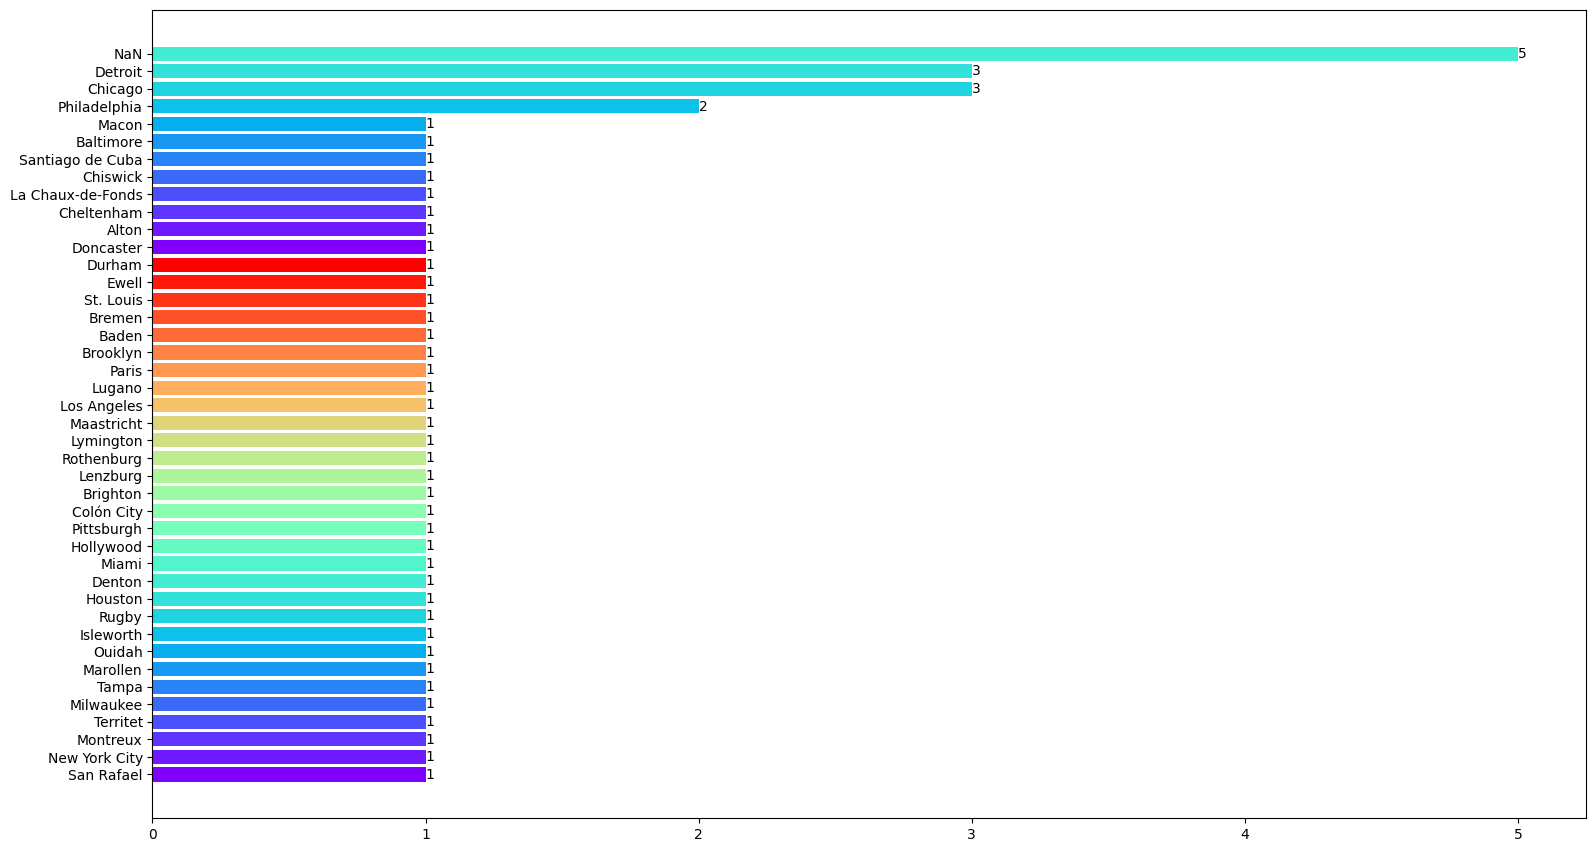

In [23]:
countries_dict = dict(sorted(Counter(countries).items(), key=lambda item: item[1]))
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
countries=list(countries_dict.keys())
countries_val=list(countries_dict.values())
colors = cm.rainbow(np.linspace(0, 1, 30))
bars = ax.barh(countries,countries_val,color=[c for c in colors])
labels_text = ax.bar_label(bars)
plt.savefig("hub_countries.eps", format="eps",bbox_inches='tight')
plt.show()

In [17]:
degrees = nx.degree(net_jazz)
artist_max_degree=0
for n in net_jazz.nodes:
    if degrees[n] == 247:
      artist_max_degree=n

In [55]:
print(artist_max_degree.instruments)

['piano', 'trumpet', 'keyboard instrument', 'drum kit', 'horn', 'synthesizer', 'voice']


In [27]:

subgraph = nx.Graph()
subgraph.add_node(artist_max_degree)
neighborhood=net_jazz.neighbors(artist_max_degree)

for n in net_jazz.neighbors(artist_max_degree):      
    if not subgraph.has_node(n):
        subgraph.add_node(n)   

    if not subgraph.has_edge(artist_max_degree,n):
      subgraph.add_edge(artist_max_degree,n,weight =  net_jazz[artist_max_degree][n]['weight'] )    
   
    for sub_n in net_jazz.neighbors(n) :          
        if sub_n in net_jazz.neighbors(artist_max_degree) :  
            if not subgraph.has_node(sub_n):
               subgraph.add_node(sub_n)   

            if not subgraph.has_edge(n,sub_n):
               subgraph.add_edge(n,sub_n,weight = net_jazz[n][sub_n]['weight']) 

###Nationality of the neighbors of Quincy Jones

In [ ]:
neighborhood_countries= list()
for n in neighborhood:
    print(n.countries)
    neighborhood_countries.extend(n.countries)

In [51]:
Counter(neighborhood_countries)

Counter({'NaN': 124,
         'United States of America': 79,
         'Switzerland': 11,
         'United Kingdom': 9,
         'Germany': 8,
         'Cuba': 5,
         'Kingdom of the Netherlands': 2,
         'France': 2,
         'Spain': 1,
         'Belgium': 1,
         'Austria': 1,
         'United Kingdom of Great Britain and Ireland': 1,
         'Cameroon': 1,
         'Canada': 1,
         'Benin': 1,
         'Brazil': 1,
         'Jordan': 1,
         'Slovakia': 1,
         'Hungary': 1})

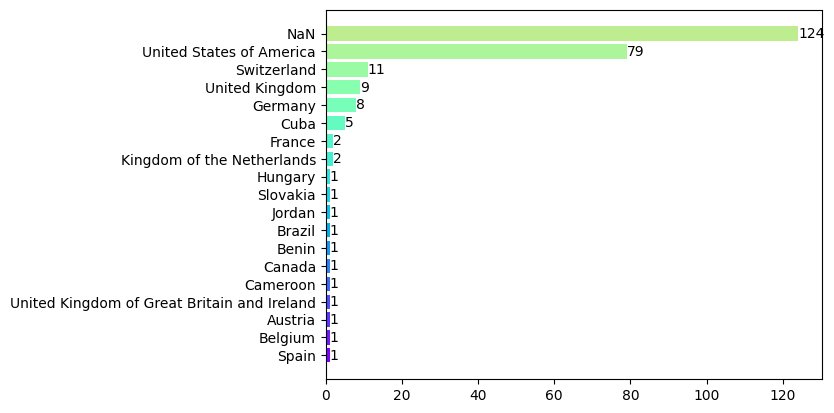

In [54]:
countries_dict = dict(sorted(Counter(neighborhood_countries).items(), key=lambda item: item[1]))
fig, ax = plt.subplots()
#fig.set_size_inches(18.5, 10.5, forward=True)
countries=list(countries_dict.keys())
countries_val=list(countries_dict.values())
colors = cm.rainbow(np.linspace(0, 1, 30))
bars = ax.barh(countries,countries_val,color=[c for c in colors])
labels_text = ax.bar_label(bars)
plt.savefig("hub_countries_quincyJ.eps", format="eps",bbox_inches='tight')
plt.show()

In [25]:
nx.write_gexf(subgraph, "./quincy_jones_network_weight_fixed.gexf")

In [28]:
get_network_info(subgraph)

nb nodes:  248
nb edges:  4480
Min node degree:  7
Max node degree:  247
Avg node degree:  36.12903225806452


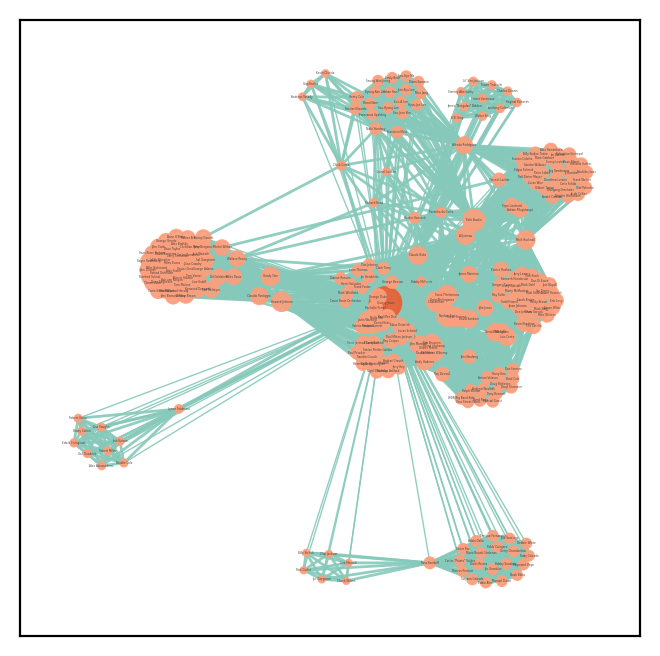

In [ ]:
pos = nx.spring_layout(subgraph, 2/math.sqrt(subgraph.order()))
d = dict(subgraph.degree())
fig, _= plt.subplots(figsize=(4, 4),  dpi=200)
color_lookup = {k:v for v, k in enumerate(sorted(set(subgraph.nodes())))}
low, *_, high = sorted(color_lookup.values())
norm = colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.tab20c) #magma
node_color = ["#eb5f34" if n == artist_max_degree else"#FD9E7B" for n in subgraph.nodes()]
weights = [subgraph[u][v]['weight']/2 for u,v in subgraph.edges()]
nx.draw_networkx(subgraph, pos=pos, node_size=[(v+1)/2 for v in d.values()], node_color =node_color, edge_color="#86C9BA", 
                 width=weights, with_labels=True, font_size = 0.4, font_color = "#393939", alpha=0.9)
plt.savefig("Graph.JPEG", format="JPEG")

###2.All network

In [ ]:
print("nb nodes: ",len(net_all.nodes))
print("nb edges: ",len(net_all.edges))
deg = dict(nx.degree(net_all))
deg = list(deg.values())
print("Min node degree: ",np.min(deg))
print("Max node degree: ",np.max(deg))
print("Avg node degree: ",np.meandeg))

nb nodes:  14513
nb edges:  89229
Min node degree:  1
Max node degree:  529
Avg node degree:  12.296423895817544


##Part2.2: Scale-free network

In [ ]:
from decimal import  Decimal
from collections import Counter

In [ ]:
def plot_degree_histogram(g,scale="log-log"):
    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    frac = [n/g.number_of_nodes() for n in cnt]
    fig, ax = plt.subplots()
    plt.plot(deg, frac, 'o')
    filename="net_jazz_linear_dist.eps"
    if scale=="log-log":
        filename="net_jazz_log_dist.eps"
        ax.set_yscale('log')
        ax.set_xscale('log')
 
    plt.ylabel("Fraction of nodes P(k)")
    plt.xlabel("Degree k")
    plt.axvline(50, color='r',label="Xmin")
    plt.legend()
    plt.savefig(filename, format="eps")
    plt.show()
   

###Part2.2.1: Jazz network

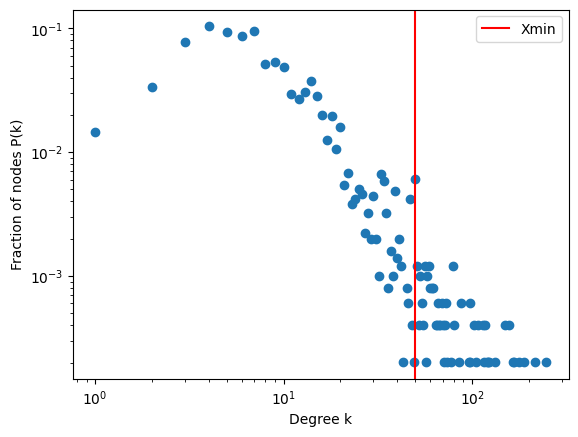

In [ ]:
plot_degree_histogram(net_jazz,"log-log")

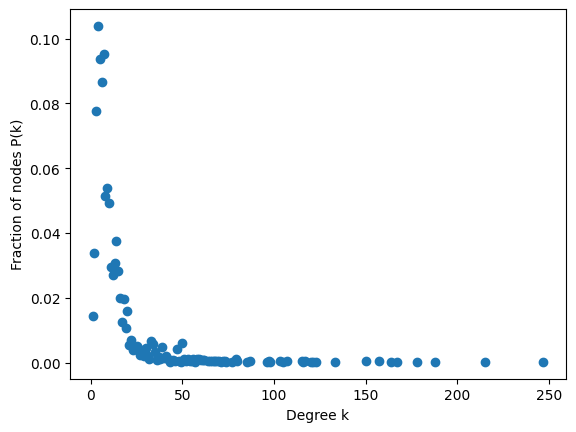

In [ ]:
plot_degree_histogram(net_jazz,"linear")

<Axes: >

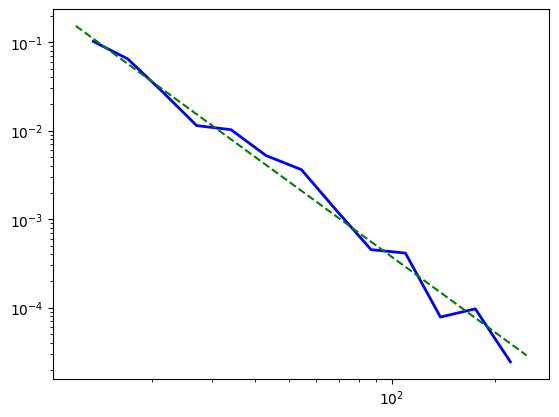

In [ ]:
deg = dict(nx.degree(net_jazz))
deg = list(deg.values())
fit = powerlaw.Fit(deg,xmin=12) 
fit.distribution_compare('power_law', 'lognormal')

fig2 = fit.plot_pdf(color='b', linewidth=2, linestyle='solid')
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)

In [ ]:
print(fit.alpha)
print(fit.xmin)

2.8356972788768378
12.0


###Part2.2.2 All network

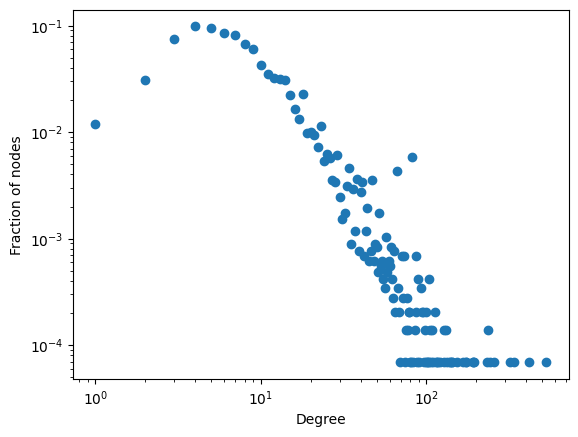

In [ ]:
plot_degree_histogram(net_all)

Calculating best minimal value for power law fit


<Axes: >

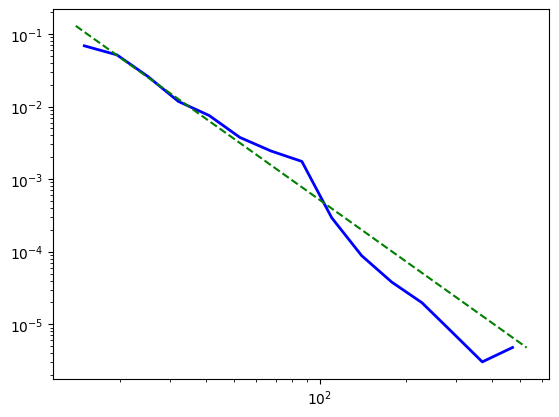

In [ ]:
deg = dict(nx.degree(net_all))
deg = list(deg.values())
fit = powerlaw.Fit(deg) 
fit.distribution_compare('power_law', 'lognormal')

fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)

In [ ]:
print(fit.alpha)

2.810675382814802


In [ ]:
def computeoccudeg(g):
      occurence = {}
      d = dict(g.degree)
      nb_musician = 0
      for key in d:
          nb_musician += 1
          if(d[key] not in occurence):
              occurence[d[key]] = 1
          else:
              occurence[d[key]] += 1
      deg = []
      occ = []
      for i in sorted(occurence.keys()):
          deg.append(i)
          occ.append(occurence[i])
      return occ, deg, nb_musician

In [ ]:
def show_distrib_pk(g):
        occ, deg, nb_musician = computeoccudeg(g)
        dict_occ_deg = {}; dict_pk = {}; dict_deg_gamma = {}
        lst_deg = []; lst_pk = []
        d = dict(g.degree())
        d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
        # For each degree count the number of node of this degree
        for name in d:
            deg = d[name]
            if(deg > 2):
                if(deg not in dict_occ_deg):
                    dict_occ_deg[deg] = 1
                else:
                    dict_occ_deg[deg] += 1
        # For each degree k compute the value of P(k)
        for deg in dict_occ_deg:
            dict_pk[deg] = dict_occ_deg[deg] / nb_musician
            lst_deg.append(deg)
            lst_pk.append(dict_pk[deg])
        #fig = plt.figure()
        plt.plot(lst_deg, lst_pk, '.')
        plt.xlabel('k', fontsize=12)
        plt.ylabel('P(k)', fontsize=12)
        plt.gca().invert_yaxis()
        plt.show()
        # For each degree k compute the value of gamma
        for deg in dict_occ_deg:
            if(deg != 0 and deg != 1 and dict_pk[deg] != 0):
                dict_deg_gamma[deg] = math.log(Decimal(1/dict_pk[deg]),deg)
        avg_gamma = 0
        # Compute the average value of gamma for the degree present in the network
        for deg in dict_deg_gamma:
            avg_gamma += dict_deg_gamma[deg]
        avg_gamma = avg_gamma/len(dict_deg_gamma)
        print("Average value of gamma : ", avg_gamma)

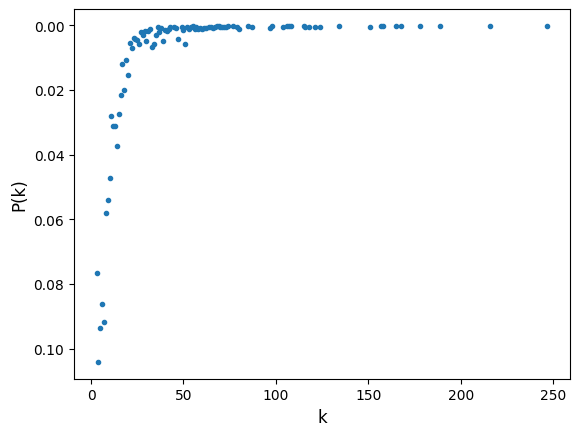

Average value of gamma :  1.6894366634098368


In [ ]:
show_distrib_pk(G)

S

In [ ]:
deg = dict(nx.degree(G))
deg = list(deg.values())
fit = powerlaw.Fit(deg) 
fit.distribution_compare('power_law', 'lognormal')

fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)

In [ ]:
fit.alpha

2.854232683624822

#Communities detection

In [ ]:
! pip install python-louvain


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx


In [50]:
communities_louvain=nx_comm.louvain_communities(net_jazz, seed=123)
print(len(communities_louvain))


237


In [51]:
communities_louvain.sort(key = len,reverse=True)

In [52]:
communities_louvain

[{'Al Di Meola',
  'Al Harrison',
  'Alain Toko',
  'Alan Stuart',
  'Albert Wing',
  'Alex Ligertwood',
  'Alfred Williams',
  'Amy Keys',
  'Andy McKee',
  'Andy Summers',
  'Andy Vargas',
  'Angel Figueroa',
  'Anthony Lindsay',
  'Anthony Nycholchev',
  'Armando Peraza',
  'Art Poter',
  'Artia Lockett',
  'Arto Tunçboyacıyan',
  'Assitan Atangana',
  'Atlee Bakkin',
  'Aïda Khann',
  'Barbara Morrison',
  'Baron Brown',
  'Bavarian Chamber Philarmonic Orchestra',
  'Ben Butler',
  'Benjamin Rietveld',
  'Bennie Maupin',
  'Beverley Knight',
  'Bhavani Shankar',
  'Bill Ortiz',
  'Bill Summers',
  'Billy Mintz',
  'Bob Frazier',
  'Bob Knapp',
  'Bobo Stenson',
  'Brandon Coleman',
  'Brian Blade',
  'Bruce Johnson',
  'Bull Moose Jackson',
  'Calder Spanier',
  'Carlos Santana',
  'Carol Shive',
  'Chad Wackerman',
  'Charles Lloyd',
  'Charlie Hunter',
  'Charlotte Dipanda',
  'Chester Thompson',
  'Chick Corea',
  'Chris Botti',
  'Chris Carrington',
  'Chris Potter',
  'Cindy B

In [53]:
len(communities_louvain[0])

270

In [ ]:
communities_lpa= list(nx_comm.asyn_lpa_communities(net_jazz,seed=123))
print(len(communities_lpa))

661


In [54]:
communities_gn= list(nx_comm.girvan_newman(net_jazz))
print(len(communities_gn))

KeyboardInterrupt: 

In [ ]:
communities_af= list(nx_comm.naive_greedy_modularity_communities(net_jazz))
print(len(communities_af))

KeyboardInterrupt: ignored

In [ ]:
print("modularity Louvain:",nx_comm.modularity(net_jazz,communities_louvain))
print("modularity LPA:",nx_comm.modularity(net_jazz,communities_lpa))
print("modularity Girvan-Newman:",nx_comm.modularity(net_jazz,communities_gn))

modularity Louvain: 0.8105460511951983
modularity LPA: 0.7042779165510524


NameError: ignored